In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import matplotlib.pyplot as plt

base_dir = '/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/DATASET'
classes = ['dark spots', 'puffy eyes', 'wrinkles', 'clear skin']
class_counts = {}

for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count
    print(f"Class '{class_name}': {count} images")



Class 'dark spots': 301 images
Class 'puffy eyes': 300 images
Class 'wrinkles': 300 images
Class 'clear skin': 300 images


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from google.colab import drive

In [ ]:
data_dir = '/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/DATASET'
classes = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
IMG_SIZE = 224
RANDOM_STATE = 42

In [ ]:
import os

class_folder = '/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/DATASET/wrinkles'
img_names = os.listdir(class_folder)
print(img_names[0:5])  # Display first 5 image names


['145.jpg', '174.jpg', '114.jpg', '153.jpg', '100.jpg']


In [ ]:

def load_images(data_dir, classes):
    """Loads images, resizes, and converts BGR to RGB."""
    data = []
    labels = []

    print("Starting image loading and resizing...")
    for idx, label in enumerate(classes):
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f"ERROR: Path not found: {path}")
            continue

        print(f"Processing class: {label}")
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                data.append(img.astype('float32'))
                labels.append(idx)
            else: print(f"Warning: Could not read image {img_name}")

    return np.array(data), np.array(labels)

In [ ]:
X, y = load_images(data_dir, classes)
X, y = shuffle(X, y, random_state=RANDOM_STATE)

y_encoded = to_categorical(y, num_classes=len(classes))

print(f"Images (X) shape: {X.shape} (Range [0, 255])")
print(f"Labels (y_encoded) shape: {y_encoded.shape} (One-Hot Encoded)")

Starting image loading and resizing...
Processing class: wrinkles
Processing class: dark spots
Processing class: puffy eyes
Processing class: clear skin
Images (X) shape: (1201, 224, 224, 3) (Range [0, 255])
Labels (y_encoded) shape: (1201, 4) (One-Hot Encoded)


/tmp/ipython-input-1652195426.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.countplot(x=label_names, palette="viridis")


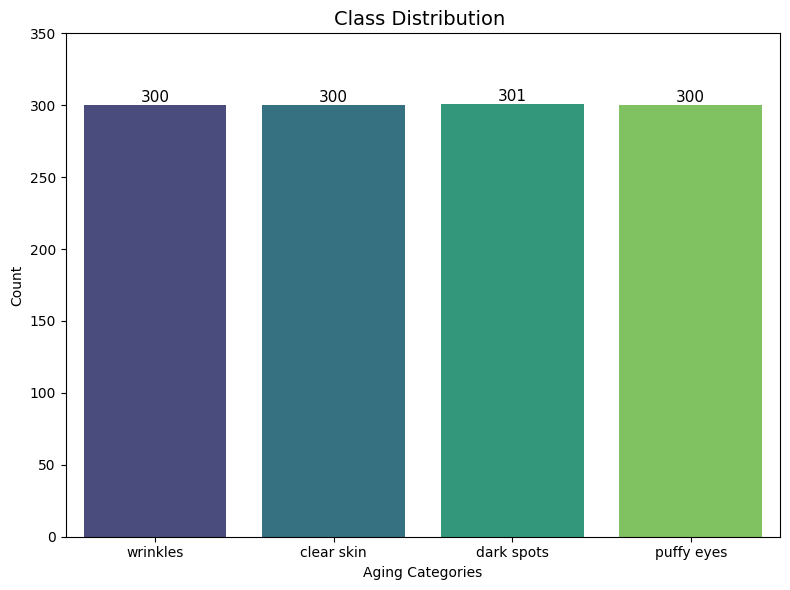

In [ ]:
label_names = [classes[i] for i in y]

plt.figure(figsize=(8, 6))
bars = sns.countplot(x=label_names, palette="viridis")
plt.title("Class Distribution ", fontsize=14)
plt.xlabel("Aging Categories")
plt.ylabel("Count")
plt.ylim(0, 350)

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}',
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='bottom', fontsize=11, color='black')

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/class_distribution_plot.png')
plt.show()


 Augmentation
Displaying 5 augmented versions of a sample image:


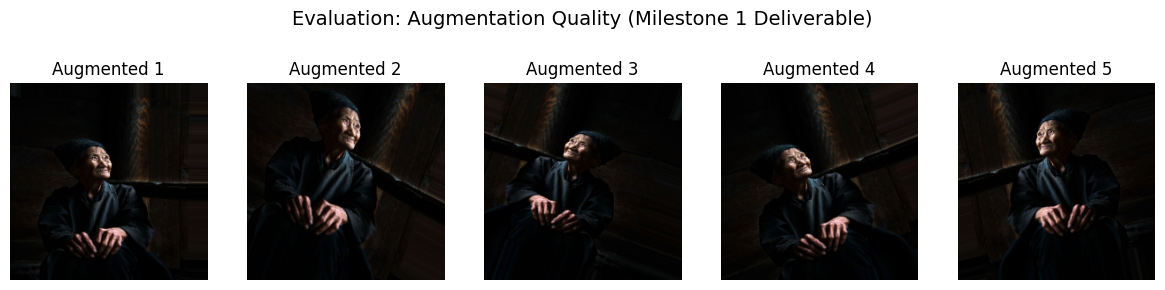

In [ ]:

print("\n Augmentation")
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_img = X[0].reshape((1,) + X[0].shape)
i = 0
plt.figure(figsize=(12, 3))
print("Displaying 5 augmented versions of a sample image:")

for batch in datagen.flow(sample_img, batch_size=1):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0] / 255.0)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
    i += 1
    if i >= 5:
        break

plt.suptitle("Evaluation: Augmentation Quality (Milestone 1 Deliverable)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/augmentation_visualization.png')

plt.show()

In [ ]:
output_dir = '/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET'
np.save(os.path.join(output_dir, 'X_data_224_rgb.npy'), X)
np.save(os.path.join(output_dir, 'y_labels_one_hot.npy'), y_encoded)

print(f"Final preprocessed data saved to: {output_dir}")



Final preprocessed data saved to: /content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET


In [ ]:
import numpy as np
X = np.load('/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/X_data_224_rgb.npy')
y = np.load('/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/DATASET/y_labels_one_hot.npy')


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8077 - loss: 0.6034

30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8074 - loss: 0.6038 - val_accuracy: 0.7884 - val_loss: 0.6273
Epoch 2/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8175 - loss: 0.6046

30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8178 - loss: 0.6042 - val_accuracy: 0.8050 - val_loss: 0.6182
Epoch 3/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8298 - loss: 0.5481

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8295 - loss: 0.5492 - val_accuracy: 0.8091 - val_loss: 0.6098
Epoch 4/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8054 - loss: 0.5678 - val_accuracy: 0.8008 - val_loss: 0.6019
Epoch 5/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8175 - loss: 0.6038 - val_accuracy: 0.8091 - val_loss: 0.5941
Epoch 6/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8330 - loss: 0.5499 - val_accuracy: 0.8050 - val_loss: 0.5870
Epoch 7/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8299 - loss: 0.5407 - val_accuracy: 0.8050 - val_loss: 0.5801
Epoch 8/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8441 - loss: 0.5207 - val_accuracy: 0.8091 - val_loss: 0.5734
Epoch 9/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8432 - loss: 0.5247 - val_accuracy: 0.8091 - val_loss: 0.5672
Epoch 10/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8360 - loss: 0.5075

30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8357 - loss: 0.5081 - val_accuracy: 0.8174 - val_loss: 0.5614
Epoch 11/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8280 - loss: 0.5234

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8280 - loss: 0.5233 - val_accuracy: 0.8216 - val_loss: 0.5558
Epoch 12/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8308 - loss: 0.5261 - val_accuracy: 0.8216 - val_loss: 0.5504
Epoch 13/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8468 - loss: 0.4983 - val_accuracy: 0.8216 - val_loss: 0.5457
Epoch 14/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8562 - loss: 0.4924

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8562 - loss: 0.4925 - val_accuracy: 0.8257 - val_loss: 0.5410
Epoch 15/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8432 - loss: 0.4788 - val_accuracy: 0.8257 - val_loss: 0.5363
Epoch 16/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8471 - loss: 0.4736 - val_accuracy: 0.8257 - val_loss: 0.5322
Epoch 17/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8426 - loss: 0.4834

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8426 - loss: 0.4835 - val_accuracy: 0.8299 - val_loss: 0.5276
Epoch 18/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8426 - loss: 0.4920 - val_accuracy: 0.8299 - val_loss: 0.5236
Epoch 19/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8492 - loss: 0.4754 - val_accuracy: 0.8299 - val_loss: 0.5199
Epoch 20/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8480 - loss: 0.4649 - val_accuracy: 0.8299 - val_loss: 0.5163
Epoch 21/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8586 - loss: 0.4352 - val_accuracy: 0.8299 - val_loss: 0.5120
Epoch 22/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8646 - loss: 0.4533

30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8642 - loss: 0.4535 - val_accuracy: 0.8340 - val_loss: 0.5091
Epoch 23/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8415 - loss: 0.4507

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8418 - loss: 0.4508 - val_accuracy: 0.8382 - val_loss: 0.5060
Epoch 24/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8182 - loss: 0.4784 - val_accuracy: 0.8340 - val_loss: 0.5030
Epoch 25/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8671 - loss: 0.4427 - val_accuracy: 0.8382 - val_loss: 0.5000
Epoch 26/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8515 - loss: 0.4597 - val_accuracy: 0.8382 - val_loss: 0.4970
Epoch 27/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8593 - loss: 0.4231

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8595 - loss: 0.4235 - val_accuracy: 0.8423 - val_loss: 0.4936
Epoch 28/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8662 - loss: 0.4325 - val_accuracy: 0.8423 - val_loss: 0.4908
Epoch 29/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8719 - loss: 0.4244 - val_accuracy: 0.8423 - val_loss: 0.4880
Epoch 30/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8570 - loss: 0.4325 - val_accuracy: 0.8423 - val_loss: 0.4851
Epoch 31/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8534 - loss: 0.4334

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8535 - loss: 0.4332 - val_accuracy: 0.8465 - val_loss: 0.4832
Epoch 32/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8730 - loss: 0.4250 - val_accuracy: 0.8423 - val_loss: 0.4806
Epoch 33/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8533 - loss: 0.4328 - val_accuracy: 0.8423 - val_loss: 0.4788
Epoch 34/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8665 - loss: 0.4235 - val_accuracy: 0.8423 - val_loss: 0.4757
Epoch 35/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8685 - loss: 0.3950 - val_accuracy: 0.8423 - val_loss: 0.4730
Epoch 36/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8642 - loss: 0.4300 - val_accuracy: 0.8465 - val_loss: 0.4710
Epoch 37/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8668 - loss: 0.4202 - val_accuracy: 0.8423 - val_loss: 0.4687
Epoch 38/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8716 - loss: 0.3888 - val_accuracy: 0.8382 - val_loss: 0.4

30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8708 - loss: 0.4043 - val_accuracy: 0.8548 - val_loss: 0.4641
Epoch 40/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8703 - loss: 0.3940 - val_accuracy: 0.8465 - val_loss: 0.4620
Epoch 41/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8713 - loss: 0.4190 - val_accuracy: 0.8465 - val_loss: 0.4601
Epoch 42/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8867 - loss: 0.3769 - val_accuracy: 0.8548 - val_loss: 0.4586
Epoch 43/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8821 - loss: 0.3857 - val_accuracy: 0.8506 - val_loss: 0.4566
Epoch 44/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8757 - loss: 0.3794 - val_accuracy: 0.8548 - val_loss: 0.4539
Epoch 45/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8724 - loss: 0.3944 - val_accuracy: 0.8548 - val_loss: 0.4521
Epoch 46/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8797 - loss: 0.3886

30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8795 - loss: 0.3884 - val_accuracy: 0.8589 - val_loss: 0.4507
Epoch 47/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8776 - loss: 0.3611 - val_accuracy: 0.8589 - val_loss: 0.4486
Epoch 48/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8793 - loss: 0.3696 - val_accuracy: 0.8589 - val_loss: 0.4467
Epoch 49/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8861 - loss: 0.3499 - val_accuracy: 0.8589 - val_loss: 0.4448
Epoch 50/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8839 - loss: 0.3712 - val_accuracy: 0.8548 - val_loss: 0.4450
Epoch 51/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8836 - loss: 0.3683

30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8834 - loss: 0.3684 - val_accuracy: 0.8631 - val_loss: 0.4425
Epoch 52/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8927 - loss: 0.3637 - val_accuracy: 0.8589 - val_loss: 0.4415
Epoch 53/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8804 - loss: 0.3808 - val_accuracy: 0.8631 - val_loss: 0.4397
Epoch 54/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8857 - loss: 0.3618 - val_accuracy: 0.8631 - val_loss: 0.4379
Epoch 55/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8796 - loss: 0.3605 - val_accuracy: 0.8631 - val_loss: 0.4371
Epoch 56/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8906 - loss: 0.3369 - val_accuracy: 0.8631 - val_loss: 0.4355
Epoch 57/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8593 - loss: 0.3842 - val_accuracy: 0.8631 - val_loss: 0.4337
Epoch 58/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8895 - loss: 0.3602 - val_accuracy: 0.8631 - val_loss: 0.4

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8871 - loss: 0.3502 - val_accuracy: 0.8672 - val_loss: 0.4209
Epoch 69/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8876 - loss: 0.3469 - val_accuracy: 0.8672 - val_loss: 0.4188
Epoch 70/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8892 - loss: 0.3682 - val_accuracy: 0.8672 - val_loss: 0.4182
Epoch 71/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8908 - loss: 0.3348 - val_accuracy: 0.8672 - val_loss: 0.4172
Epoch 72/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8793 - loss: 0.3451

30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8800 - loss: 0.3445 - val_accuracy: 0.8714 - val_loss: 0.4158
Epoch 73/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8867 - loss: 0.3276

30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8868 - loss: 0.3276 - val_accuracy: 0.8755 - val_loss: 0.4150
Epoch 74/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8996 - loss: 0.3344 - val_accuracy: 0.8714 - val_loss: 0.4137
Epoch 75/75
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8828 - loss: 0.3396 - val_accuracy: 0.8714 - val_loss: 0.4125


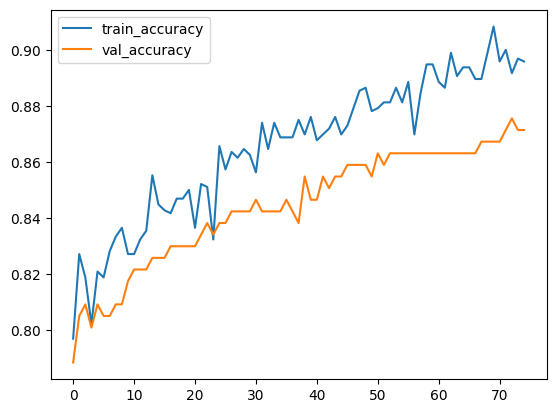

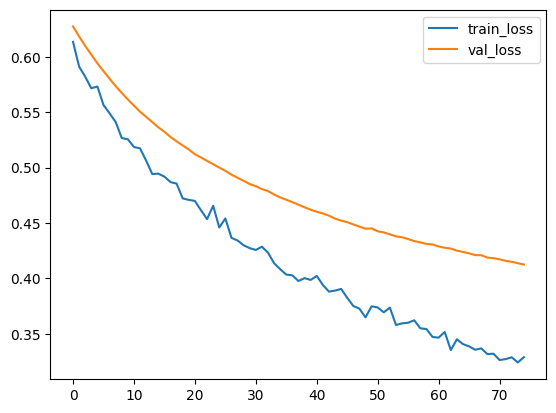

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/FACIAL-AGING-PROJECT/efficientnet_facial_aging.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.2, epochs=75, batch_size=32, callbacks=[checkpoint, early_stop])

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Use the same split as before training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

val_preds = model.predict(X_val)  # Shape: (num_samples, num_classes)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(y_val, axis=1)



8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


Validation Accuracy: 0.9045643153526971
Classification Report:
              precision    recall  f1-score   support

    wrinkles       0.84      0.80      0.82        54
  dark spots       0.93      0.96      0.95        56
  puffy eyes       0.86      0.88      0.87        65
  clear skin       0.97      0.97      0.97        66

    accuracy                           0.90       241
   macro avg       0.90      0.90      0.90       241
weighted avg       0.90      0.90      0.90       241



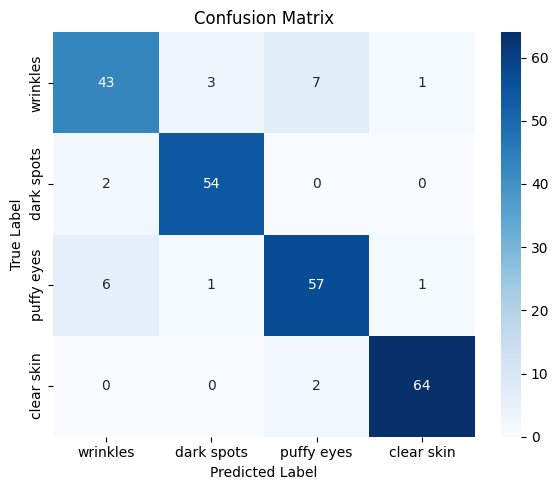

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
acc = accuracy_score(val_true_classes, val_pred_classes)
print("Validation Accuracy:", acc)

# Full report (includes precision, recall, F1-score per class)
print("Classification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(val_true_classes, val_pred_classes)

# Set up class labels
labels = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()

# Save as PNG
plt.savefig('confusion_matrix.png')
plt.show()

